**9장 - 비지도 학습**

***이 노트북은 9장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다.***

# 설정

In [1]:
import sys 
assert sys.version_info >= (3,5)

import sklearn
sklearn.__version__ >= "0.20"

import numpy as np
import os 

np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = 'unsupervised_learning'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# 군집 



**소개 - 분류 vs 군집**

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

그림 저장: classification_vs_cluster_plot


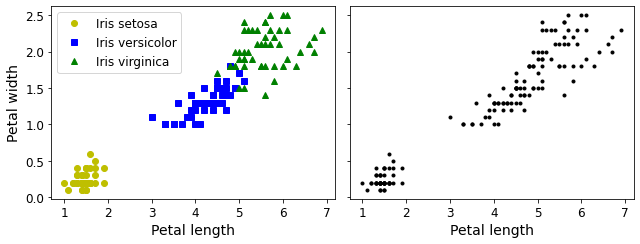

In [4]:
plt.figure(figsize=(9,3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], 'yo', label='Iris setosa')
plt.plot(X[y==1, 2], X[y==1, 3], 'bs', label='Iris versicolor')
plt.plot(X[y==2, 2], X[y==2, 3], 'g^', label='Iris virginica')
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:,2], X[:,3], c='k', marker='.')
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_cluster_plot")
plt.show()

(아래에서 설명할) 가우시안 혼합 모델은 3개의 클러스터를 잘 나눌 수 있습니다(꽃잎 길이와 너비, 꽃받침 길이와 너비 4개의 특성을 모두 사용합니다).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

각 클러스터를 하나의 클래스에 매핑해보죠. 이 매핑을 (책에서처럼) 하드 코딩하는 대신 (```scipy.stats.mode()``` 함수를 사용해) 각 클러스터에서 가장 많은 클래스를 선택합니다:

In [7]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
from scipy import stats
mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] =class_id

mapping

{1: 0, 2: 1, 0: 2}

In [9]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

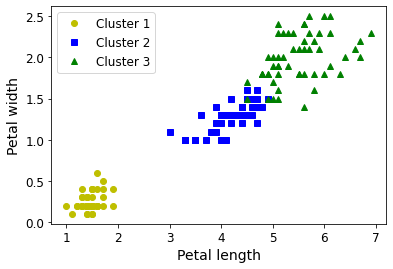

In [10]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], 'yo', label='Cluster 1')
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], 'bs', label='Cluster 2')
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], 'g^', label='Cluster 3')
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [11]:
np.sum(y_pred==y)

145

In [12]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

**노트**:사이킷런 알고리즘이 이따금 업데이트 되기 떄문에 이 노트북의 결과가 책과 조금 다를 수 있습니다.

# k-평균

먼저 예제 데이터를 생성해 보죠:

In [13]:
from sklearn.datasets import make_blobs

In [14]:
blob_centers = np.array([
    [0.2, 2.3],
    [-1.5, 2.3],
    [-2.8, 1.8],
    [-2.8, 2.8],
    [-2.8, 1.3]
])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [15]:
X, y =make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

데이터를 그래프로 그립니다:

In [16]:
def plot_clusters(X, y=None):
    plt.scatter(X[:,0], X[:,1], c=y, s=1)
    plt.xlabel("$x_1$",fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)


그림 저장: blobs_plot


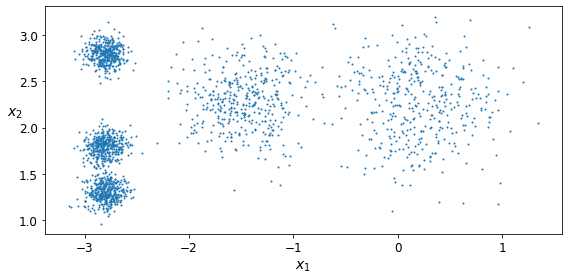

In [17]:
plt.figure(figsize=(8,4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

**훈련과 예측**

이 데이터셋에 K-평균 알고리즘을 훈련해 보겠습니다. 이 알고리즘은 클러스터 중심을 찾고 각 샘플을 가까운 클러스터에 할당합니다:

In [18]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

각 샘플은 5개의 클러스터 중 하나에 할당됩니다:

In [19]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [20]:
y_pred is kmeans.labels_

True

5개의 ***센트로이드***(즉 클러스터 중심)을 찾았습니다:

In [21]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

``KMeans``객체는 훈련한 샘플의 레이블을 가지고 있습니다. 조금 혼동스럽지만 여기에서 샘플의 ***레이블***은 샘플에 할당된 클러스터의 인덱스입니다:

In [22]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0])

물론 새로운 샘플의 레이어블을 예측할 수 있습니다:

In [23]:
X_new = np.array([[0,2], [3,2], [-3,3], [-3,2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

**결정 경계**

이 모델의 결정경계를 그려 보죠. 이 그림은 ***보로노이 다이어그램***이 됩니다:

In [24]:
def plot_data(X):
    plt.plot(X[:,0],X[:,1], 'k.', markersize=2)
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max()/ 10]
    plt.scatter(centroids[:,0], centroids[:,1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:,0], centroids[:,1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy =np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                        np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap='Pastel2')
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


그림 저장: voronoi_plot


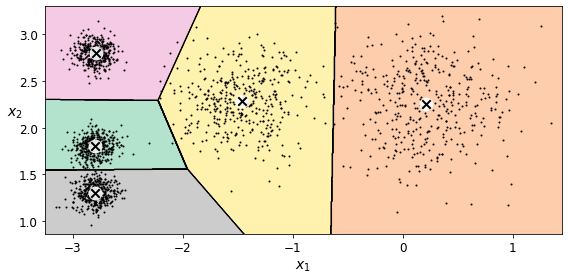

In [25]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()


나쁘지 않군요! 경계 근처에 있는 일부 샘플은 아마도 잘못 클러스터에 할당된 것 같습니다. 하지만 전반적으로 아주 좋은 것 같습니다.

**하드 군집 vs 소프트 군집**

***하드 군집***은 각 샘플에 대해 가장 가까운 클러스터를 선택합니다. 이 대신 샘플에서 5개의 센틀이드까지 거리를 측정하는 것이 나올 수 있습니다. ```transform()```메서드에서 이 거리를 계산합니다.

In [26]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

이 거리가 샘플과 센트로이드 사이의 유클리드 거리인지 확인할 수 있습니다:

In [27]:
np.linalg.norm(np.tile(X_new, (1,k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

# K-평균 알고리즘

K-평균 알고리즘은 가장 빠르고 가장 간단한 군집 알고리즘 중 하나입니다:
- 먼저 **$k$**개의 센트로이드를 랜덤하게 초기화합니다: 데이터셋에서 **$k$**개의 샘플을 랜덤하게 선택하고 센트로이드를 그 위치에 놓습니다.
- 수렴할 때까지 다음을 반복합니다.(즉, 센트로이드가 더이상 작동하지 않을때까지):
    - 각 샘플을 가장 가까운 센트로이드에 할당합니다. 
    - 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트합니다.

```KMeans``` 클래스는 기본적으로 최적화된 알고리즘을 적용합니다. (교육적인 목적으로) 원래 K-평균 알고리즘을 사용하려면 ```init='randomen_init=1```, ```algorithm="full"```로 설정해야합니다. 이 매개변수들은 아래에서 설명하겠습니다.

K-평균 알고리즘을 1,2,3회 반복하고 센트로이드가 어떻게 움직이는지 확인해보겠습니다:

In [28]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=2,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=3,
                      algorithm="full", max_iter=3, random_state=0)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=3,
       random_state=0)

그래프를 그려 보죠:

그림 저장: kmeans_algorithm_plot


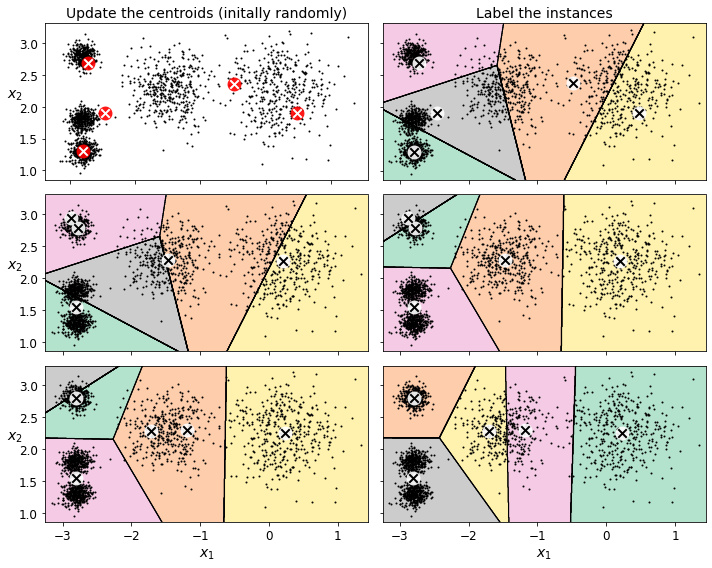

In [29]:
plt.figure(figsize=(10,8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initally randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False, show_xlabels=True, show_ylabels=True)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_xlabels=True, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

**K-평균의 변동성**

원래 K-평균 알고리즘에서는 센트로이드가 그냥 랜덤하게 초기되고 알고리즘은 단순히 한번씩 반복하여 앞서 본 것처럼 점차 센트로이드를 개선시킵니다.

하지만 이 방식의 문제점은 K-평균을 여러번 (또는 다른 랜덤 시드로) 실행하면 아래에서 보듯이 매우 다른 결과를 얻게 됩니다:

In [30]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)
    
    plt.figure(figsize=(10,3.2))
    
    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)
    
    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X)
    if title2:
        plt.title(title2, fontsize=14)

C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


그림 저장: kmeans_variablity_plot


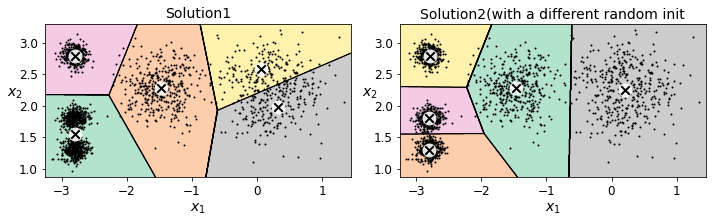

In [31]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm='full', random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm='full', random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X, "Solution1", "Solution2(with a different random init")

save_fig("kmeans_variablity_plot")
plt.show()

# 이너셔

최선의 모델을 선택하려면 K-평균 모델의 성능을 평가할 방법이 있어야 합니다. 안타깝지만 군집은 비지도 학습이기 때문에 타깃이 없습니다. 하지만 적어도 각 샘플과 센트로이드 사이의 거리는 측정할 수 있습니다. 이것이 ***이너셔*** 지표의 아이디어입니다:

In [32]:
kmeans.inertia_

211.59853725816836

이너셔는 각 훈련 샘플과 가장 가까운 센트로이드 사이의 제곱 거리의 합으로 쉽게 검증할 수 있습니다:

In [33]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581685

```score()``` 메서드는 음의 이너셔를 반환합니다. 왜 음수일까요? 사이킷런의 ```score()``` 메서드는 항상 "***큰 값이 좋은 것***" 규칙을 따라야 하기 때문입니다.

In [34]:
kmeans.score(X)

-211.59853725816836

# 다중 초기화

변동성 이슈를 해결하는 한 방법은 단순히 K-평균 알고리즘을 랜덤 초기화를 다르게 하여 여러 번 실행하고 가장 작은 이너셔를 만드는 솔루션을 선택합니다. 예를 들어 앞선 그림에 있는 엉터리 모델 두 개의 이너셔는 다음과 같습니다. 

In [35]:
kmeans_rnd_init1.inertia_

219.43539442771407

In [36]:
kmeans_rnd_init2.inertia_

211.59853725816836

여기서 볼 수 있듯이 앞서 훈련한 "좋은"모델보다 이너셔가 더 높습니다. 즉 더 나쁘다는 것을 의미합니다,

```n_init``` 매개변수를 지정하면 사이킷런은 원래 알고리즘을 ```n_init```번 실행하고 이너셔가 가장 작은 솔루션을 선택합니다. 이 매개변수의 기본값은 ```n_init=10```입니다.

In [37]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                             algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

여기에서 볼 수 있듯이 결국 처음 만들었던 모델을 얻엇습니다. 이 모델이 최적의 K-평균 결과로 보입니다.(**$k = 5$** 라고 가정하고 이너셔를 기준으로 했을 때입니다.)

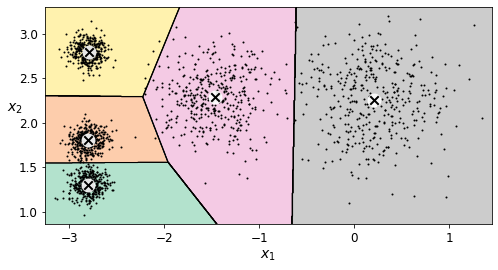

In [38]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

# 센트로이드 초기화 방법

센트로이드를 완전히 랜덤하게 초기화하는 대신 David Arthur와 Sergei Vassilvitskii가 2006년 논문에서 제안한 다음 알고리즘을 사용해 초기화하는 것이 더 좋습니다:

- 데이터셋에서 무작위로 균등하게 하나의 센트로이드 $c_1$을 선택합니다.
- $D(x_i)^2 / \sum\limits_{j=1}^{m}D(x_j)^2$의 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$로 선택합니다. 여기에서 $D(x_i)$는 샘플 $x_i$에서 이미 선택된 가장 가까운 센트로이드까지 거리입니다. 이 확률 분포는 이미 선택한 센트로이드에서 멀리 떨어진 샘플을 센트로이드로 선택할 가능성을 높입니다. 
- $k$ 개의 센트로이드를 선택할때까지 이전 단계를 반복합니다.

K-평균++ 알고리즘의 나머지는 일반 K-평균과 같습니다. 이 초기화 방식을 사용하면 K-평균 알고리즘이 최적의 솔루션에 수렴할 가능성을 훨씬 높아집니다. 따라서 ```n_init``` 값을 상당히 줄일 수 있습니다. 대부분의 경우 ```n_init```을 줄이는 것이 초기화 과정에 추가된 복잡도를 보상합니다.

K-평균++ 초기화를 사용하려면 간단하게 ```init="k-means++"```로 지정하면 됩니다.(사실 이 값이 기본값입니다.):

In [39]:
KMeans()

KMeans()

In [40]:
good_init = np.array([[-3,3], [-3,2], [-3,1], [-1,2], [0,2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

# 미니배치 K-평균

사이킷런은 미니배치를 지원하는 K-평균 방식도 제공합니다.

In [41]:
from sklearn.cluster import MiniBatchKMeans

In [42]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

In [43]:
minibatch_kmeans.inertia_

211.65239850433204

데이터셋이 메모리에 다 들어가지 못하면 가장 간단한 방법은 이전 장의 점진적 PCA에서 했던 것처럼 ```memmap``` 클래스를 사용하는 것입니다. 먼저 MNIST 데이터를 로드합니다:

In [44]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mnist['data'], mnist['target'], random_state=42)

```memmap```에 데이터를 기록합니다:

In [46]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [47]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

데이터가 너무 커서 ```memmap```을 사용할 수 없다면 문제는 더 복잡해집니다. 배치를 로드하는 함수를 먼저 만들어 보죠(실전에서는 디스크에서 데이터를 먼저 로드합니다):

In [48]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

한 번에 하나의 배치를 모델에 주입하여 훈련할 수 있습니다. 또한 여러 번 초기화를 수행하고 이너셔가 가장 낮은 모델을 선택합니다:

In [49]:
np.random.seed(42)

In [50]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500 # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    
    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_
    
    if (best_kmeans is None or 
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\Hands-On-MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent 

In [51]:
best_kmeans.score(X)

-211.62571878891143

미니배치 K-평균이 일반 K-평균보다 훨씬 빠릅니다:

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

50.9 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

131 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


***훨씬*** 빠르군요! 하지만 성능이 낮은 (즉 이너셔가 높은) 경우가 많습니다. k가 증가할수록 더 그렇습니다. 미니배치 K-평균과 일반 K-평균 사이에 이너셔와 훈련 시간을 그래프로 나타내 보겠습니다:

In [55]:
from timeit import timeit

In [56]:
times = np.empty((100,2))
inertias = np.empty((100,2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k,100, end=""))
    times[k-1, 0] = timeit('kmeans_.fit(X)', number=10, globals=globals())
    times[k-1, 1] = timeit('minibatch_kmeans.fit(X)', number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


그림 저장: minibatch_kmeans_vs_kmeans


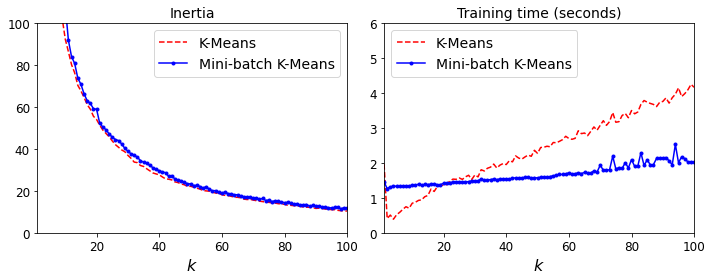

In [57]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1,101), inertias[:,0], 'r--', label='K-Means')
plt.plot(range(1,101), inertias[:,1], 'b.-', label='Mini-batch K-Means')
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1,100,0,100])

plt.subplot(122)
plt.plot(range(1,101), times[:,0], 'r--', label="K-Means")
plt.plot(range(1,101), times[:,1], 'b.-', label='Mini-batch K-Means')
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.legend(fontsize=14, loc="upper left")
plt.axis([1,100,0,6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

# 최적의 클러스터 개수 찾기

클러스터 개수가 5보다 작거나 크게 지정하면 어떨까요 ? 

그림 저장: bad_n_clusters_plot


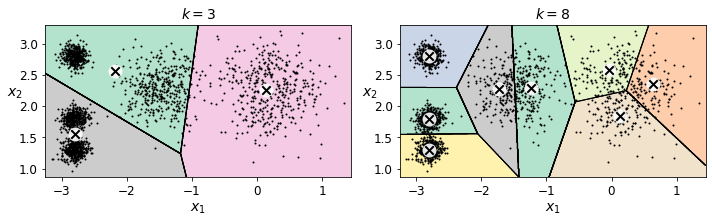

In [58]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig('bad_n_clusters_plot')
plt.show()

두 모델 모두 좋아 보이지 않는군요. 이너셔는 어떨까요?

In [59]:
kmeans_k3.inertia_

653.2167190021554

In [60]:
kmeans_k8.inertia_

119.1198341610288

$k$가 증가할수록 이너셔가 줄어들기 때문에 단순히 이너셔가 작은 $k$를 선택할 수 없군요. 실제 클러스터가 많을수록 샘플은 인접한 센트로이드에 더 가깝습니다. 따라서 이너셔가 더 작습니다. 하지만 $k$에 대한 이너셔를 그래프로 그리고 결과 그래프를 조사해 볼 수 있습니다. 

In [61]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

그림 저장: inertia_vs_k_plot


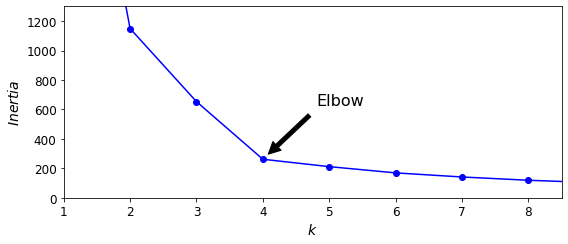

In [62]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1,10), inertias, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("$Inertia$", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
             )
plt.axis([1, 8.5, 0, 1300])
save_fig('inertia_vs_k_plot')
plt.show()

여기에서 볼 수 있듯이 $k=4$에서 엘보우가 있습니다. 이 값보다 클러스터가 작으면 나쁘다는 뜻입니다. 이보다 더 많으면 크게 도움이 되지 않고 배로 늘려도 그렇습니다. 따라서 $k=4$가 아주 좋은 선택입니다. 물론 이 예제에서는 이 값이 완벽하지 않습니다. 왼쪽 아래 두 클러스터가 하나의 클러스로 간주되었지만 꽤 좋은 군집 결과입니다.

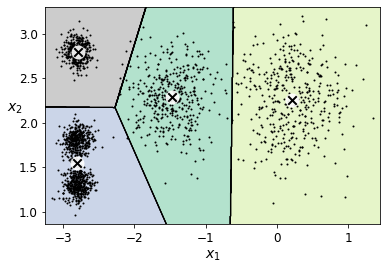

In [63]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

또 다른 방법은 모든 샘플에 대한 ***실루엣 계수***의 평균인 ***실루엣 점수***입니다. 한 샘플의 실루엣 계수는 $(b-a) / \text{max}(a,b)$입니다. 여기에서 $a$는 같은 클러스터에 있는 다른 샘플까지의 평균 거리입니다.(이를 클러스터 내부 평균 거리라고 합니다.) $b$는 가장 가까운 클러스터까지 평균 거리입니다. 즉 가장 가까운 클러스터(샘플 자신의 클러스터를 제외하고 $b$를 최소화하는 클러스터)의 샘플까지 평균 거리입니다. 실루엣 계수는 -1에서 +1 사이의 값을 가집니다. +1에 가까우면 샘플이 다른 클러스터로부터 떨어져 자신의 클러스터에 잘 있다는 것을 의미합니다. 0에 가까우면 클러스터 경계에 가깝다는 의미입니다. -1에 가까우면 샘플이 잘못된 클러스터에 할당되었을지 모릅니다.

$k$에 대한 실루엣 점수를 그래프로 그려보죠:

In [64]:
from sklearn.metrics import silhouette_score

In [65]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [66]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

그림 저장: silhoutte_score_vs_k_plot


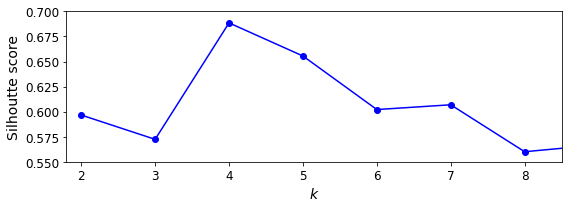

In [67]:
plt.figure(figsize=(8,3))
plt.plot(range(2,10), silhouette_scores, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhoutte score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhoutte_score_vs_k_plot")
plt.show()

여기에서 볼 수 있듯이 이 그래프는 이전보다 정보가 더 풍부합니다. 특히 $k=4$가 매우 좋은 선택이지만 $k=5$도 꽤 괜찮은 선택이라는 것을 보여줍니다.

모든 샘플의 실루엣 계수를 할당된 클러스터와 실루엣 값으로 정렬하여 그리면 훨씬 많은 정보를 알 수 있습니다. 이를 ***실루엣 다이어그램***이라고 합니다:

그림 저장: silhouette_analysis_plot


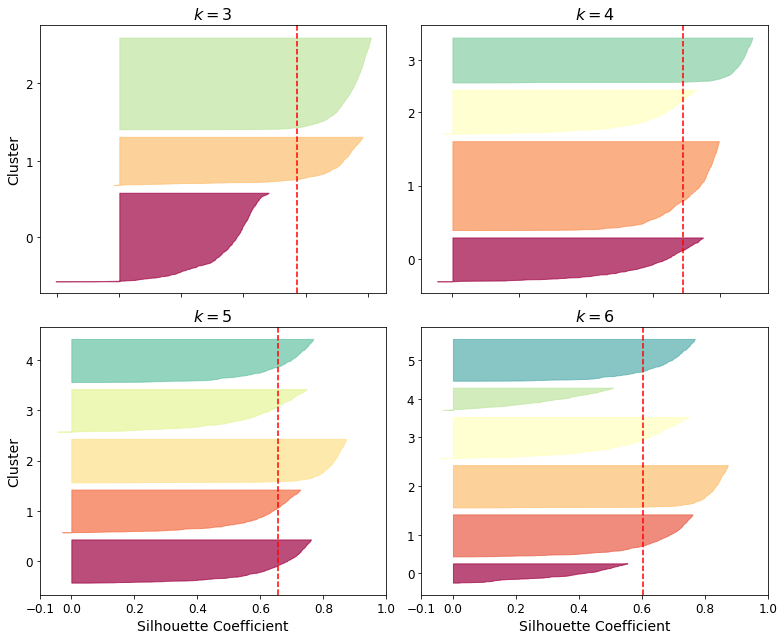

In [68]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

여기에서 볼 수 있듯이 $k=5$가 가장 좋은 선택입니다. 모든 클러스터의 크기가 거의 동일하고 평균 실루엣 점수를 나타내는 파선을 모두 넘었습니다.

# K-평균의 한계

In [69]:
X1, y1 = make_blobs(n_samples=1000, centers=((4,-4), (0,0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

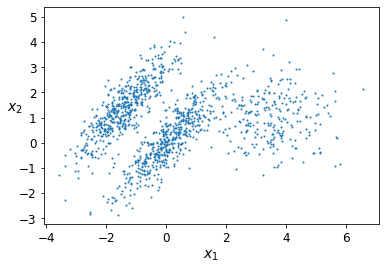

In [70]:
plot_clusters(X)

In [71]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5,2.5], [0.5,0], [4,0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

그림 저장: bad_kmeans_plot


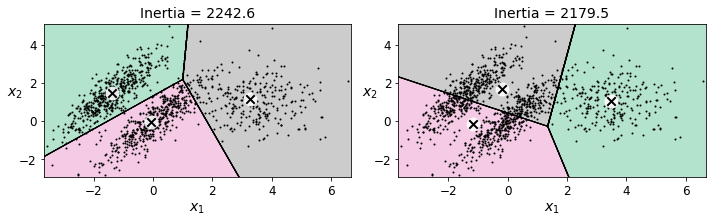

In [72]:
plt.figure(figsize=(10,3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

# 군집을 사용한 이미지 분할

In [73]:
# 무당벌레 이미지를 다운로드합니다.
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x21b97db4dc0>)

In [74]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

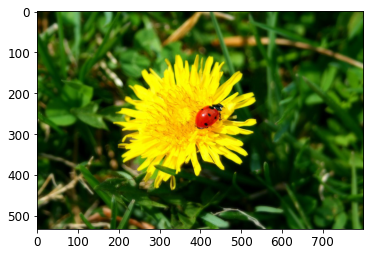

In [75]:
plt.imshow(image)

In [76]:
X = image.reshape(-1,3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [77]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

그림 저장: imaage_segmentation_diagram


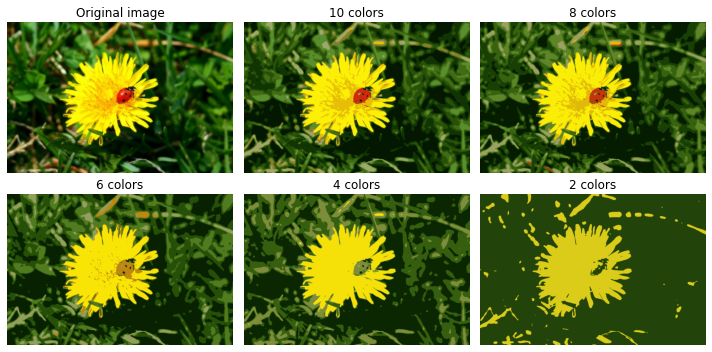

In [78]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title('{} colors'.format(n_clusters))
    plt.axis('off')

save_fig('imaage_segmentation_diagram', tight_layout=True)
plt.show()

# 군집을 사용한 전처리

MNIST와 유사하게 숫자 0에서 9까지 8x8 흑백 이미지 1,797개로 이루어진 ***숫자 데이터셋***을 다루어 보겠습니다.

In [79]:
from sklearn.datasets import load_digits

In [80]:
X_digits, y_digits = load_digits(return_X_y=True)

훈련 세트와 테스트 세트로 나눕니다:

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

로지스틱 회귀 모델을 훈련하고 테스트 세트에서 평가합니다:

In [83]:
from sklearn.linear_model import LogisticRegression

In [84]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [85]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

좋습니다. 기본 모델의 정확도는 96.89%입니다. 이제 K-평균을 전처리 단계로 사용해 더 향상할 수 있는지 알아 보죠. 훈련 세트를 50개의 클러스터로 만들고 이미지를 이 클러스터까지 거리로 바꾼 다음 로지스틱 회귀 모델을 적용하는 파이프라인을 만듭니다. 

In [86]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50, random_state=42)),
    ('log_reg', LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [87]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

얼마나 오차가 감소했나요?

In [88]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

어떤가요 ? 오차율을 35%나 줄였습니다! 하지만 클러스터 개수 $k$를 임의로 결정했습니다. 이 보다 더 나은 방법이 있겠죠. K-평균을 분류 파이프라인에서 전처리 단계로 사용했기 떄문에 좋은 $k$값을 찾는 것은 이전보다 더 쉽습ㄴ디ㅏ. 실루엣 분석을 수행하거나 이너셔를 최소화할 필요가 없습니다. 가장 좋은 $k$값은 가장 좋은 분류 성능을 내는 것입니다.

In [89]:
from sklearn.model_selection import GridSearchCV

In [90]:
param_grid = dict(kmeans__n_clusters=range(2,20))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.1s
[CV] END ...............................kmeans__

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 20)}, verbose=2)

최고의 클러스터 개수를 확인해보죠:

In [91]:
grid_clf.best_params_

{'kmeans__n_clusters': 18}

In [92]:
grid_clf.score(X_test, y_test)

0.96